In [1]:
import CHONK_cpp as ch
import numpy as np
import fastscapelib_fortran as fs
import lsdtopytools as lsd
import numba as nb
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.display import clear_output, display
nrows = 100
ncols = 100
xres = 100
yres = 100

xmin = 0
xmax = ncols*yres
ymin = 0
ymax = nrows*xres
# Z = np.load("elev_breaking_stack.npy")
Z = np.random.rand(nrows,ncols)
# Z = np.load("SS_100_100_MFA.npy")
lsd.raster_loader.save_raster(Z.reshape(nrows,ncols),
   0,xres*ncols,yres*nrows,0,xres,"epsg:32635","current_Z.tif", fmt = 'GTIFF')
lsd.raster_loader.save_raster(np.arange(nrows*ncols).reshape(nrows,ncols).astype(np.int32),
   0,xres*ncols,yres*nrows,0,xres,"epsg:32635","current_ID.tif", fmt = 'GTIFF')

model = ch.ModelRunner( 1, 0, ["drainage_area","move","basic_SPIL"], "MF_fastscapelib_threshold_SF") # "MF_fastscapelib"
model.set_lake_switch(False)
model.update_array_double_param("surface_elevation", Z.ravel())
model.update_double_param("x_min", xmin)
model.update_double_param("y_min", ymin)
model.update_double_param("x_max", xmax)
model.update_double_param("y_max", ymax)
model.update_double_param("dx", xres)
model.update_double_param("dy", yres)
model.update_double_param("no_data", -9999)
model.update_int_param("n_rows", nrows)
model.update_int_param("n_cols", ncols)
model.update_int_param("n_elements", nrows*ncols)
model.update_array_double_param("surface_elevation_tp1", np.copy(Z.ravel()))
model.update_array_double_param("sed_height", np.zeros_like(Z.ravel()))
model.update_array_double_param("sed_height_tp1", np.zeros_like(Z.ravel()))
model.update_array_double_param("lake_depth", np.zeros_like(Z.ravel()))
model.update_double_param("SPIL_n", 1)
model.update_double_param("SPIL_m", 0.45)
model.update_double_param("threshold_single_flow", 5e5)
this_K = np.zeros_like(Z.ravel())+1e-4
model.update_array_double_param("erodibility_K", np.zeros_like(Z.ravel())+1e-3)
active = np.zeros((nrows,ncols), dtype = np.int)
# active[1:-1,1:-1:] = 1
active[1:-1,:] = 1
print(active.astype(np.bool))
print(active)
model.update_array_int_param("active_nodes", active.ravel())



[[False False False ... False False False]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [False False False ... False False False]]
[[0 0 0 ... 0 0 0]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]


In [2]:
fs.fastscape_init()
fs.fastscape_set_nx_ny(ncols,nrows)
fs.fastscape_setup()
fs.fastscape_set_xl_yl(xmax - xmin, ymax - ymin)
fs.fastscape_set_bc(1010)
fstctx = fs.fastscapecontext
fstctx.p = 3





In [3]:
ch.set_DEBUG_switch_nodegraph(["SAFE_STACK_STOPPER", "EXTENSIVE_STACK_INFO"], [True,True]) 

In [27]:
uplift = np.zeros((nrows,ncols))
# uplift[1:-1,1:-1:] = 0.001
uplift[1:-1,:] = 0.001
uplift[10:20,:] +=  0.004
uplift = uplift.ravel() 
dt = 100
model.update_timestep(dt)

model.update_array_double_param("erodibility_K", np.zeros_like(Z.ravel())+1e-4)

model.set_lake_switch(True)

# for i in range(1):
for i in range(100):
    new_elev = model.get_array_double_param("surface_elevation_tp1") + (uplift * dt)

#     new_elev = np.random.rand(nrows *ncols) 
    new_elev += np.random.rand(new_elev.shape[0]) * 1e-6
    lsd.raster_loader.save_raster(Z.reshape(nrows,ncols),
   0,xres*ncols,yres*nrows,0,xres,"epsg:32635","current_Z.tif", fmt = 'GTIFF')
    lsd.raster_loader.save_raster(np.arange(nrows*ncols).reshape(nrows,ncols).astype(np.int32),
   0,xres*ncols,yres*nrows,0,xres,"epsg:32635","current_ID.tif", fmt = 'GTIFF')

    model.update_array_double_param("surface_elevation", new_elev)
    model.update_array_double_param("surface_elevation_tp1", new_elev)
    model.update_array_double_param("sed_height", model.get_array_double_param("sed_height_tp1"))
    fstctx.h = new_elev
    fstctx.mrec = np.zeros_like(fstctx.mrec) -1
    fs.find_stacks_with_intermediate_save ()
    model.update_array_int_param("D8stack",fstctx.stack0 - 1)
    model.update_array_int_param("D8rec",fstctx.rec0 - 1)
    model.update_array_int_param("Prec",fstctx.rec - 1)
    model.update_array_double_param("D8Length",fstctx.length)
    model.update_array2d_int_param("Mrec",fstctx.mrec.astype('int').transpose() - 1)
    model.update_array2d_double_param("Mlength",fstctx.mlrec.transpose())
    model.update_array2d_double_param("external_weigths_water",fstctx.mwrec.transpose())
#      this->graph = NodeGraphV2(this->io_int_array["D8stack"], this->io_int_array["D8rec"], this->io_double_array["D8Length"],
# this->io_int_array2d["Mrec"] , this->io_double_array2d["Mlength"], this->io_double_array["surface_elevation"], this->io_double["dx"], this->io_double["dy"]);
    
    model.initiate_nodegraph()
    
    model.run()
    print(i, end= "|")
    
    
    

0|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|25|26|27|28|29|30|31|32|33|34|35|36|37|38|39|40|41|42|43|44|45|46|47|48|49|50|51|52|53|54|55|56|57|58|59|60|61|62|63|64|65|66|67|68|69|70|71|72|73|74|75|76|77|78|79|80|81|82|83|84|85|86|87|88|89|90|91|92|93|94|95|96|97|98|99|

0.011678601630285541


Text(0, 0.5, 'Y (m)')

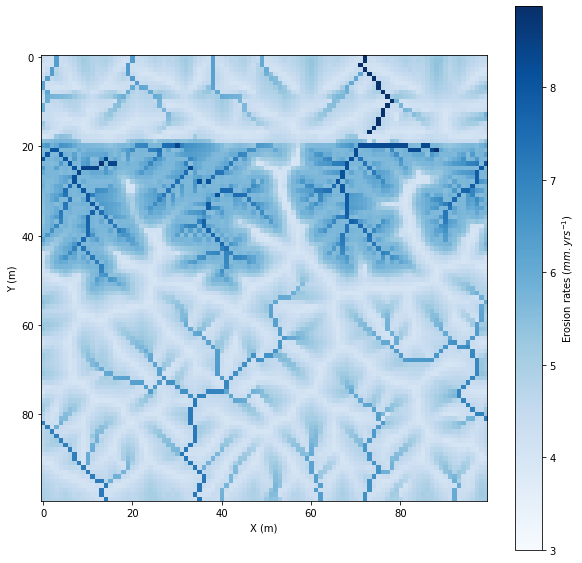

In [30]:
Zp1 = model.get_array_double_param("surface_elevation_tp1")
print(np.min(Zp1))

fig,ax = plt.subplots(figsize = (10,10))

# cb = ax.imshow(Z.reshape(raster["nrows"],raster["ncols"])- Zp1.reshape(raster["nrows"],raster["ncols"]), 
#      cmap = "viridis")
# model.get_water_flux()
noerr = np.copy(Zp1.reshape(nrows,ncols))
noerr[noerr>0] = np.nan
 
cb = ax.imshow(Zp1.reshape(nrows,ncols), vmin = 0, cmap = "gray", extent = [xmin,xmax,ymin,ymax])


lake = model.get_array_double_param("lake_depth").reshape(nrows,ncols)
lake = np.abs(lake)
lake[lake<=0] = np.nan
ax.imshow(lake,vmin =-5, vmax = -4, cmap = "Blues", extent = [xmin,xmax,ymin,ymax])
cb = ax.imshow(np.log10(model.get_water_flux().reshape(nrows,ncols)), vmin = 3, cmap = "Blues")
# cb = ax.imshow((Zp1 - tempsave).reshape(nrows,ncols), vmin = 0, cmap = "gist_earth", extent = [xmin,xmax,ymin,ymax])
# cb = ax.imshow(model.get_other_attribute("lake_depth").reshape(nrows,ncols), vmin = 0,     cmap = "viridis")
# cb = ax.imshow(model.get_erosion_flux().reshape(nrows,ncols), cmap = "viridis")
# cb = ax.imshow(model.get_sediment_flux().reshape(nrows,ncols), cmap = "viridis")

# cb = ax.imshow(model.get_all_nodes_in_depression().reshape(nrows,ncols), cmap = "viridis")
# cb = ax.imshow(model.DEBUG_get_preacc().reshape(nrows,ncols), cmap = "viridis")
# cb = ax.imshow(model.get_array_double_param("sed_height_tp1").reshape(nrows,ncols), cmap = "viridis")


# cb = ax.imshow(Z.reshape(raster["nrows"],raster["ncols"])[600:700,400:500] - Zp1.reshape(raster["nrows"],raster["ncols"])[600:700,400:500], 
#     vmin = -0.1,vmax = 0.5, cmap = "viridis")
# cb = ax.imshow(Z.reshape(raster["nrows"],raster["ncols"])[550:650,400:500], cmap = "viridis",vmin = 500, vmax = 800 )
plt.colorbar(cb, label = r"Erosion rates $(mm.yrs^{-1})$")
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")


In [6]:




ch.set_DEBUG_switch_nodegraph(["SAFE_STACK_STOPPER", "EXTENSIVE_STACK_INFO"], [True,True]) 
# ch.set_DEBUG_switch_nodegraph(["SAFE_STACK_STOPPER", "EXTENSIVE_STACK_INFO"], [False,True]) 


In [3]:
new_elev = new_elev.reshape(nrows,ncols)
# new_elev[20:20,15:15] = new_elev[20:20,15:15] -  20
new_elev[0:2,:] = 0
new_elev[-2:,:] = 0
new_elev = new_elev.ravel()
model.update_array_double_param("surface_elevation_tp1", new_elev)
model.update_array_double_param("surface_elevation", new_elev)


NameError: name 'new_elev' is not defined

In [ ]:
this_K = np.zeros_like(Z.ravel())+1e-4

popup_elev = ch.pop_elevation_to_SS_SF_SPIL(fstctx.stack -1, fstctx.rec -1,fstctx.length , uplift, this_K, 0.9, 0.45, xres*yres)
pZ = np.copy(popup_elev)

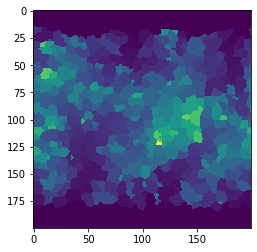

In [6]:
plt.imshow(pZ.reshape(nrows, ncols))
model.update_array_double_param("surface_elevation_tp1", pZ)

model.update_array_double_param("surface_elevation", pZ)


In [13]:
mfst = np.copy(fstctx.mstack.astype('int') - 1)
print(model.get_array_int_param("MF_stack") - mfst)
print(np.unique(model.get_array_int_param("MF_stack") - mfst))

[0 0 0 ... 0 0 0]
[0]


In [8]:
Prec = fstctx.rec - 1
don = fstctx.don.transpose() - 1
ndon = fstctx.ndon
rec = fstctx.mrec.transpose() - 1
# print(model.get_array_int_param("MF_rec")[792])
# print(model.get_array_int_param("MF_stack")[2080])
# print(Prec[2080])
# print(model.DEBUG_get_receivers_at_node(2390))
# print(model.DEBUG_get_donors_at_node(2390))
rec[300]
ndon[300]

0

In [9]:
lsd.raster_loader.save_raster(model.get_array_double_param("surface_elevation").reshape(nrows,ncols),
   0,xres*ncols,yres*nrows,0,xres,"epsg:32635","nodegraphv2_topo.tif", fmt = 'GTIFF')
lsd.raster_loader.save_raster(np.arange(nrows*ncols).astype(np.int32).reshape(nrows,ncols),
   0,xres*ncols,yres*nrows,0,xres,"epsg:32635","nodegraphv2_ID.tif", fmt = 'GTIFF')
lsd.raster_loader.save_raster(np.log10(model.get_water_flux().reshape(nrows,ncols)).reshape(nrows,ncols),
   0,xres*ncols,yres*nrows,0,xres,"epsg:32635","nodegraphv2_logDA.tif", fmt = 'GTIFF')
arr = model.get_array_double_param("lake_depth").reshape(nrows,ncols)
arr[arr<=0] = -9999
lsd.raster_loader.save_raster(arr,
   0,xres*ncols,yres*nrows,0,xres,"epsg:32635","nodegraphv2_lake_depth.tif", fmt = 'GTIFF')
caspers = model.get_broken_nodes()
ARR = np.zeros_like(Z.ravel())
ARR[caspers]=1
lsd.raster_loader.save_raster(ARR.reshape(nrows,ncols),0,xres*ncols,yres*nrows,0,xres,"epsg:32635","nodegraphv2_broken_nodes.tif", fmt = 'GTIFF')

In [16]:
model.update_double_param("threshold_single_flow", 1e5)


In [8]:
np.save("SS_100_100_MFA.npy",model.get_array_double_param("surface_elevation"))

In [10]:
caspers = model.get_broken_nodes()
print(caspers)

[]


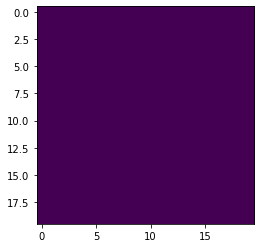

In [11]:
ARR = np.zeros_like(Z.ravel())
ARR[caspers]=1
plt.imshow(ARR.reshape(nrows,ncols))

In [16]:
from io import StringIO
import pandas as pd
res = """ID|donor|score
79|178|1638
80|181|537
81|182|536
180|281|534
877|978|507
976|1077|470
1175|1176|460
1274|1273|1593
1275|1176|460
1374|1273|1593
1375|1276|461
1376|1477|435
1474|1373|1594
1475|1576|433
1476|1577|431
1573|1672|1576
1574|1673|1577
1575|1676|432
1674|1774|1537
1675|1776|415
1775|1776|415
2000|1999|705
2001|1900|715
2002|1901|717
2003|1902|722
2004|1905|848
2005|1906|847
2073|1974|1535
2079|1980|413
2080|1981|412
2085|1986|388
2097|1998|707
2098|1999|705
2099|1999|705
2105|2006|2468
2106|2207|2102
2172|2071|1546
2174|2075|1536
2175|2076|426
2177|2076|426
2182|2282|2616
2183|2282|2616
2196|2095|709
2198|2197|2097
2200|2399|2160
2204|2305|2483
2205|2305|2483
2206|2207|2102
2271|2171|2135
2275|2176|427
2276|2176|427
2287|2386|3221
2294|2395|3340
2295|2396|3337
2297|2197|2097
2298|2197|2097
2299|2398|2159
2300|2399|2160
2304|2405|2482
2371|2272|2136
2390|2289|367
2392|2491|3319
2393|2492|3320
2394|2495|3305
2400|2399|2160
2401|2500|3285
2404|2405|2482
2467|2368|1532
2469|2368|1532
2470|2471|2993
2489|2588|3216
2501|2600|3283
2502|2603|2162
2503|2603|2162
2504|2603|2162
2568|2669|3066
2602|2702|2161
2604|2603|2162
2703|2702|2161"""
df = pd.read_csv(StringIO(res.replace("|",",")))

In [17]:
df[df['score'] == df['score'].min()]

,ID,donor,score
60,2390,2289,367
